In [1]:
import sys
sys.path.append(r"C:\Users\JosephMjehovich\OneDrive - IFDATA LLC\jmj_testing\jmjlib")
from jmjlib import trace

import numpy as np
import matplotlib.pyplot as plt


## Pure Tone Test — Sanity Check

**Goal:** Verify `instantaneous_frequency()` returns a constant frequency for a pure sine wave.

- Signal: $x(t) = \sin(2\pi f_0 t)$, where $f_0 = 10$ Hz  
- Sampling rate: $f_s = 1000$ Hz  
- Duration: 1 s

**Steps:**
1. Generate time vector and sine wave.
2. Wrap in `Signal` class.
3. Call `instantaneous_frequency()`.
4. Check:
   - Mean frequency $\approx 10$ Hz
   - Standard deviation $\ll 1$ Hz



In [2]:
# generate signal data
duration = 1
fs = 1000
f0 = 10
t = np.arange(0, duration, 1/fs)
y = np.sin(2 * np.pi * f0 * t)

# wrap signal
sig = trace.Trace(y, time=t)

# return mean and std
envelope, inst_freq = sig.instantaneous_frequency()

assert abs(np.mean(inst_freq.data) - f0) < 0.1  # tolerance you choose
assert np.std(inst_freq.data) < 0.5

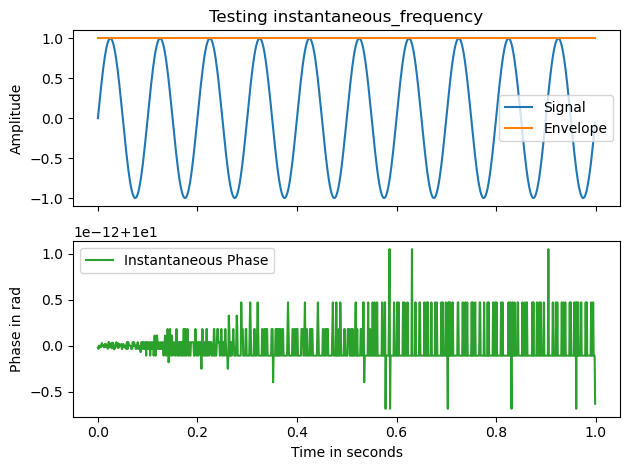

In [3]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True)
ax0.set_title("Testing instantaneous_frequency")
ax0.set_ylabel("Amplitude")
ax0.plot(t, y, label='Signal')
ax0.plot(t, envelope.data, label='Envelope')
ax0.legend()
ax1.set(xlabel="Time in seconds", ylabel="Phase in rad")
ax1.plot(t, inst_freq.data, 'C2-', label='Instantaneous Phase')
ax1.legend()
plt.show()

## Amplitude Modulation Test

**Goal:** Check envelope and frequency behavior under AM.

- Signal: $( x(t) = \bigl(1 + 0.5\sin(2\pi f_{mod} t)\bigr)\sin(2\pi f_0 t) ), with ( f_0 = 10 ) Hz, ( f_{mod} = 2 )$ Hz  
- Sampling rate: 1000 Hz, duration = 1 s

**Tasks:**
1. Compute envelope and verify it tracks $( 1 + 0.5\sin(2\pi f_{mod} t))$ (e.g., via correlation or normalized comparison).  
2. Confirm instantaneous frequency stays ≈ $( f_0 )$ despite amplitude modulation.

In [5]:
duration = 1
fs = 1000
f0 = 10
fmod = 2
t = np.arange(0, duration, 1/fs)
y = (1 + 0.5 * np.sin(2 * np.pi * fmod * t)) * np.sin(2 * np.pi * f0 * t)


# wrap signal
sig = trace.Trace(y, time=t)

# return mean and std
envelope, inst_freq = sig.instantaneous_frequency()

trim = 10
env_trim = envelope.data[trim:-trim]
inst_f_trim = inst_freq.data[trim:-trim]

# envelope should correlate with modulation
mod_env = 1 + 0.5 * np.sin(2 * np.pi * fmod * t)
mod_env_trim = mod_env[trim:-trim]
corr = np.corrcoef(envelope.data, mod_env)[0,1]
assert corr > 0.98
# frequency near carrier
mean_freq = np.mean(inst_f_trim)
assert abs(mean_freq - f0) / f0 < 0.01


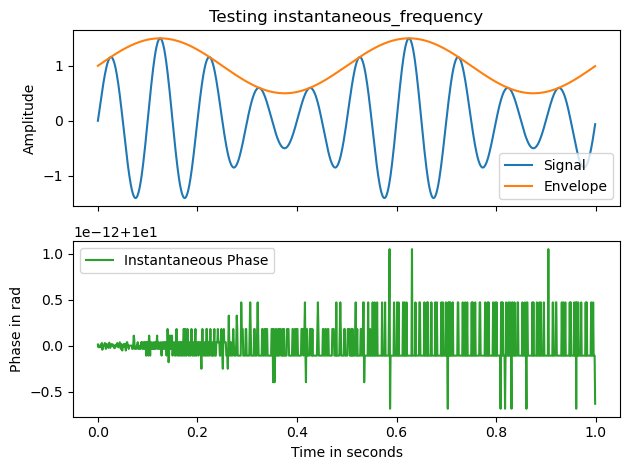

In [6]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True)
ax0.set_title("Testing instantaneous_frequency")
ax0.set_ylabel("Amplitude")
ax0.plot(t, y, label='Signal')
ax0.plot(t, envelope.data, label='Envelope')

ax0.legend()
ax1.set(xlabel="Time in seconds", ylabel="Phase in rad")
ax1.plot(t, inst_freq.data, 'C2-', label='Instantaneous Phase')
ax1.legend()
plt.show()

## Frequency Modulation Test — Linear Chirp

**Goal:** Verify `instantaneous_frequency()` accurately tracks a linearly increasing frequency.

**Signal:** Linear chirp from 5 Hz to 20 Hz over 1 second.  
True frequency law: f(t) = 5 + 15 * t  
Sampling rate: 1000 Hz, duration = 1 s

**Tasks:**
1. Generate chirp signal.
2. Wrap in `Signal` class and compute instantaneous frequency.
3. Plot instantaneous frequency vs. time, overlaying the true f(t) curve.


In [7]:
from scipy.signal import chirp

duration = 1
fs = 1000
f0 = 5
f1 = 20
t = np.arange(0, duration, 1/fs)
y = chirp(t, 5, t[-1], 20)

# wrap signal
sig = trace.Trace(y, time=t)

# return mean and std
envelope, inst_freq = sig.instantaneous_frequency()

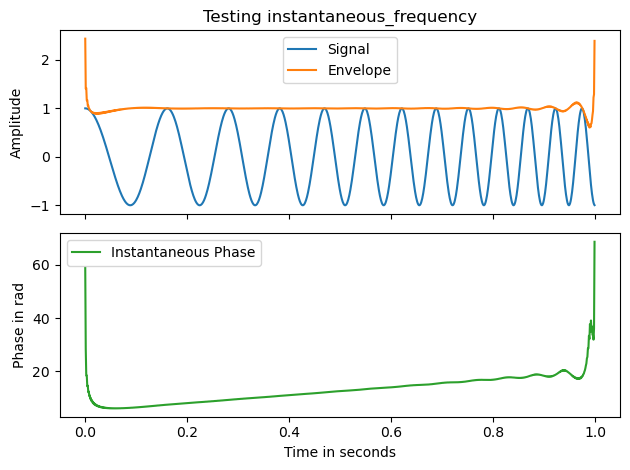

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True)
ax0.set_title("Testing instantaneous_frequency")
ax0.set_ylabel("Amplitude")
ax0.plot(t, y, label='Signal')
ax0.plot(t, envelope.data, label='Envelope')

ax0.legend()
ax1.set(xlabel="Time in seconds", ylabel="Phase in rad")
ax1.plot(t, inst_freq.data, 'C2-', label='Instantaneous Phase')
ax1.legend()
plt.show()

## Compare to scipy.sigal hilbert example

**Goal:** Verify results match official example

**Signal:** Linear chirp from 20 Hz to 100 Hz over 1 second with modulation.

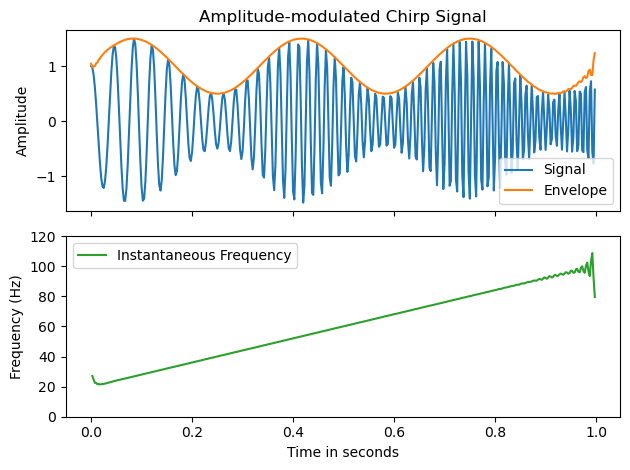

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

import sys
sys.path.append(r"C:\Users\JosephMjehovich\OneDrive - IFDATA LLC\jmj_testing\jmjlib")
from jmjlib import trace

duration, fs = 1, 400  # 1 s signal with sampling frequency of 400 Hz
t = np.arange(int(fs*duration)) / fs  # timestamps of samples
sig = chirp(t, 20.0, t[-1], 100.0)
sig *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

analytic_signal = trace.Trace(sig, time=t)
amplitude_envelope, instantaneous_frequency = analytic_signal.instantaneous_frequency()

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex='all', tight_layout=True)
ax0.set_title("Amplitude-modulated Chirp Signal")
ax0.set_ylabel("Amplitude")
ax0.plot(t, sig, label='Signal')
ax0.plot(t, amplitude_envelope.data, label='Envelope')
ax0.legend()
ax1.set(xlabel="Time in seconds", ylabel="Frequency (Hz)", ylim=(0, 120))
ax1.plot(t[1:], instantaneous_frequency.data[1:], 'C2-', label='Instantaneous Frequency')
ax1.legend()
plt.show()